In [305]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt


# Daily Data

## Dataset

In [261]:
df = pd.read_csv('final_dataset_bsky_news.csv')

In [263]:
df = pre.basic_proc_final_dataset(df)

In [265]:
df_weekly = pre.generate_weekly_df(df)

### Datos para el modelo
- X = matriz obtenida del impact_score_pipeline con los score de cada componente individual.
- y = clasificación binaria, 1 (hay pico de actividad) y 0 (no hay pico de actividad)

In [271]:
# Creamos la columna que será la target para el impact_score

# Porcentaje de crecimiento de la actividad
df = pre.activity_score_pca(df)
df['activity_growth_percentage'] = df['activity_score_pca'].pct_change() * 100
df['activity_growth_percentage'] = df['activity_growth_percentage'].fillna(0)

df_weekly = pre.activity_score_pca(df_weekly)
df_weekly['activity_growth_percentage'] = df_weekly['activity_score_pca'].pct_change() * 100
df_weekly['activity_growth_percentage'] = df_weekly['activity_growth_percentage'].fillna(0)

In [273]:
df.describe()

,tot_users,new_users,activity_score_pca,activity_growth_percentage
count,7.010000e+02,7.010000e+02,701.000000,701.000000
mean,9.325658e+06,4.917347e+04,0.000000,-6.729808
std,1.054796e+07,1.077515e+05,2.142227,155.693905
min,3.152200e+04,0.000000e+00,-1.725821,-3739.994787
25%,1.789001e+06,6.923476e+03,-1.277605,-1.763255
50%,5.586096e+06,1.455950e+04,-1.134542,0.004092
75%,1.124966e+07,4.679100e+04,0.786780,1.713578
max,3.450212e+07,1.014757e+06,8.717566,1145.383310


In [275]:
df_weekly.describe()

,tot_users,new_users,activity_score_pca,activity_growth_percentage
count,1.010000e+02,1.010000e+02,1.010000e+02,101.000000
mean,9.683269e+06,3.411242e+05,2.638154e-17,-8.515248
std,1.090816e+07,6.532057e+05,2.165758e+00,97.030657
min,4.857800e+04,0.000000e+00,-1.721089e+00,-804.737874
25%,1.879556e+06,5.889335e+04,-1.303349e+00,-6.299352
50%,5.606840e+06,1.019165e+05,-1.171124e+00,0.000000
75%,1.195171e+07,3.396960e+05,1.093075e+00,2.668641
max,3.450212e+07,4.071047e+06,7.556809e+00,366.422920


**Threshold**
- Para el daily, utilizamos el percentil 97% como threshold para los picos de crecimiento.
- Para el weekly, utilizamos el percentil de 90%, tratamos de mantener una coherencia entre ambos datasets.
- Por encima será 1, por debajo será 0. 

In [277]:
# Definimos el threshold para el dataset diario

threshold = df['activity_growth_percentage'].quantile(0.93)
print('threshold', threshold)

# Creamos la nueva columna target binaria
df['has_activity_peak'] = (df['activity_growth_percentage'] > threshold).astype(int)

threshold 10.878291705690257


In [ ]:
# X = matriz de scores de comportamiento
X = impact_score_pipeline.fit_transform(X_news)

# y = pico de actividad (0 no hay pico, 1 sí hay pico)
threshold = df['activity_growth_percentage'].quantile(0.93)
df['has_activity_peak'] = (df['activity_growth_percentage'] > threshold).astype(int)


In [279]:
# Evaluamos distribución
print(df.has_activity_peak.value_counts())
print('Porcentaje de 1: ', 56/645)

has_activity_peak
0    652
1     49
Name: count, dtype: int64
Porcentaje de 1:  0.08682170542635659


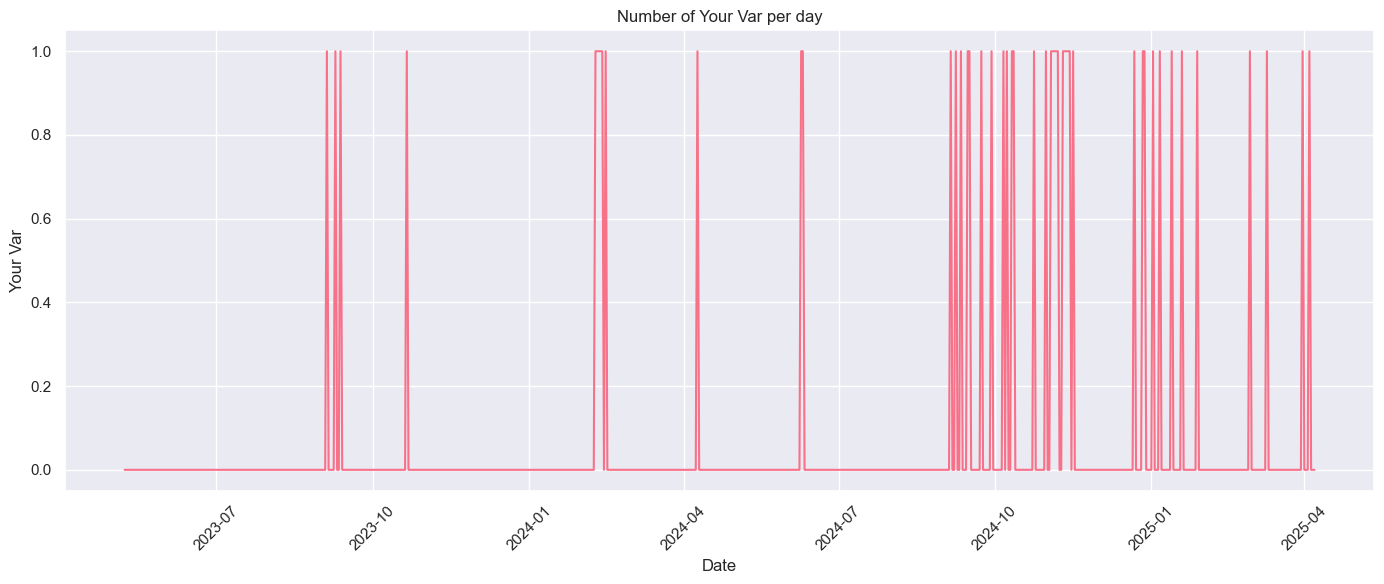

In [281]:
ep.var_per_day(df['has_activity_peak'])

In [295]:
# Definimos el threshold para el dataset semanal

threshold = df_weekly['activity_growth_percentage'].quantile(0.87)
print('threshold', threshold)

# Creamos la nueva columna target binaria
df_weekly['has_activity_peak'] = (df_weekly['activity_growth_percentage'] > threshold).astype(int)

threshold 8.072892525405063


In [299]:
# Evaluamos distribución
print(df_weekly.has_activity_peak.value_counts())
print('Porcentaje de 1: ', 13/88)

has_activity_peak
0    88
1    13
Name: count, dtype: int64
Porcentaje de 1:  0.14772727272727273


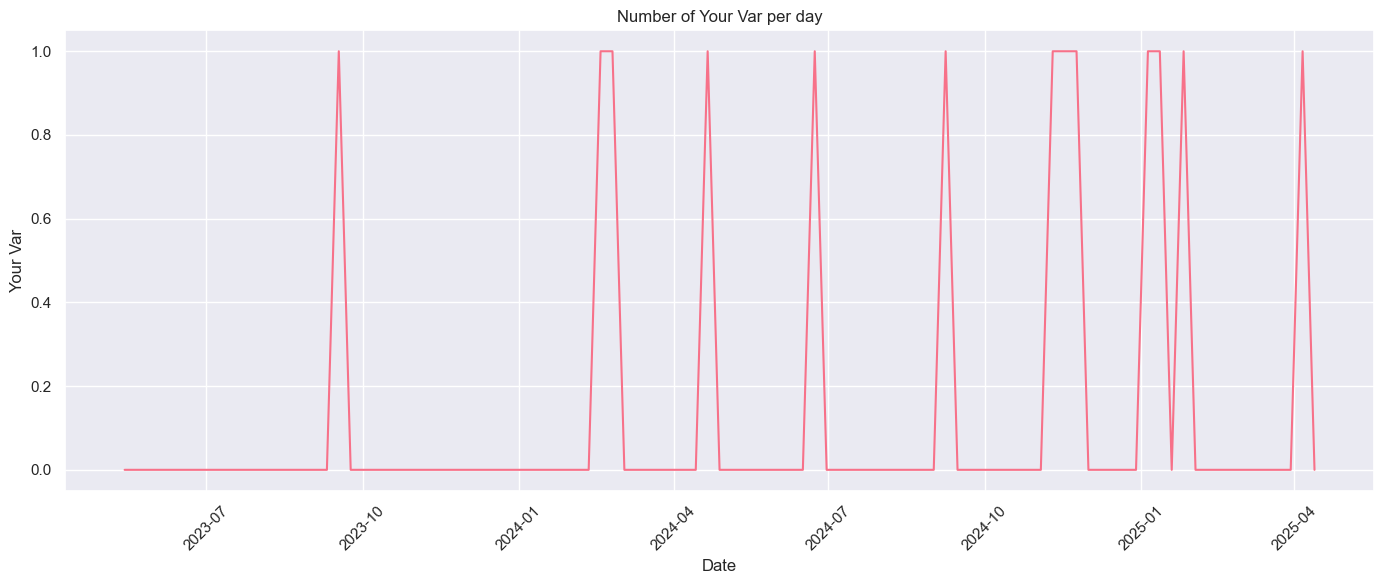

In [301]:
ep.var_per_day(df_weekly['has_activity_peak'])

**Dataframe de solo texto**

In [303]:
# Separamos los datos de texto (daily)
df_text = df.drop(columns = df._get_numeric_data().columns)

In [305]:
# Separamos los datos de texto (weekly)
df_text_weekly = df_weekly.drop(columns = df_weekly._get_numeric_data().columns)

**Train-Test Split**, manteniendo la línea temporal

In [308]:
### DAILY
# Preparamos los datos del train: registros de 2023 y 2024 completos
X_train = df_text.loc['2023-05-08':'2024-12-31',:]
y_train = df.loc['2023-05-08':'2024-12-31','has_activity_peak']

# Preparamos los datos que generarán el score, de 2025
X_test = df_text.loc['2025-01-01':,:]
y_test = df.loc['2025-01-01':,'has_activity_peak']

In [310]:
### WEEKLY
# Preparamos los datos del train: registros de 2023 y 2024 completos
X_train_weekly = df_text_weekly.loc['2023-05-08':'2024-12-31',:]
y_train_weekly = df_weekly.loc['2023-05-08':'2024-12-31','has_activity_peak']

# Preparamos los datos que generarán el score, de 2025
X_test_weekly = df_text_weekly.loc['2025-01-01':,:]
y_test_weekly = df_weekly.loc['2025-01-01':,'has_activity_peak']

In [312]:
X_test_weekly.index

DatetimeIndex(['2025-01-05', '2025-01-12', '2025-01-19', '2025-01-26',
               '2025-02-02', '2025-02-09', '2025-02-16', '2025-02-23',
               '2025-03-02', '2025-03-09', '2025-03-16', '2025-03-23',
               '2025-03-30', '2025-04-06', '2025-04-13'],
              dtype='datetime64[ns]', name='date', freq='W-SUN')

In [222]:
### DAILY
# Transformamos los datos de train con el pipeline
X_train_is = impact_score_pipeline.fit_transform(X_train)

Device set to use cpu


In [223]:
X_test_is = impact_score_pipeline.fit_transform(X_test)

Device set to use cpu


In [314]:
### WEEKLY
# Transformamos los datos de train con el pipeline
X_train_is_weekly = impact_score_pipeline.fit_transform(X_train_weekly)

Device set to use cpu


In [315]:
X_test_is_weekly = impact_score_pipeline.fit_transform(X_test_weekly)

Device set to use cpu


In [226]:
# Código para comprobar las salidas de todos los componentes
for name, transformer in impact_score_pipeline.transformer_list:
    print(f"Running: {name}")
    output = transformer.fit_transform(X_test_weekly)
    print(f"{name} output shape: {output.shape}")

Running: sentiment


Device set to use cpu


sentiment output shape: (15, 18)
Running: category
category output shape: (15, 18)
Running: ner
ner output shape: (15, 18)
Running: novelty
novelty output shape: (15, 1)


In [227]:
#Comprobamos que el resultado es correcto y no tiene errores (daily)
print('type: ', type(X_train_is), type(X_test_is))
print('shape: ', X_train_is.shape, X_test_is.shape)
print('NaN o Infinitos: ', np.any(np.isnan(X_train_is)), np.any(np.isinf(X_train_is)))
print('NaN o Infinitos: ', np.any(np.isnan(X_test_is)), np.any(np.isinf(X_test_is)))

type:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape:  (604, 55) (97, 55)
NaN o Infinitos:  False False
NaN o Infinitos:  False False


In [316]:
#Comprobamos que el resultado es correcto y no tiene errores (weekly)
print('type: ', type(X_train_is_weekly), type(X_test_is_weekly))
print('shape: ', X_train_is_weekly.shape, X_test_is_weekly.shape)
print('NaN o Infinitos: ', np.any(np.isnan(X_train_is_weekly)), np.any(np.isinf(X_train_is_weekly)))
print('NaN o Infinitos: ', np.any(np.isnan(X_test_is_weekly)), np.any(np.isinf(X_test_is_weekly)))

type:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape:  (86, 55) (15, 55)
NaN o Infinitos:  False False
NaN o Infinitos:  False False


In [308]:
# RENOMBRAMOS DATOS PARA EL MODELO

### Train (2023 - 2024)
X_ = X_train_is
y_ = y_train
y_ = y_.values.ravel() # Para convertirlo en una sola línea

### Datos para Impact Score (2025)
X_2025 = X_test_is

# No se necesitan datos de la y
y_2025 = y_test
y_2025 = y_2025.values.ravel() # Para convertirlo en una sola línea

In [309]:
# Train-test Split
total_reg = len(X_)
test_size = 0.15
total_test = round(total_reg*test_size)
total_train = total_reg-total_test
steps = total_test

X_train = X_[:-steps]
y_train = y_[:-steps]

X_test  = X_[-steps:]
y_test  = y_[-steps:]

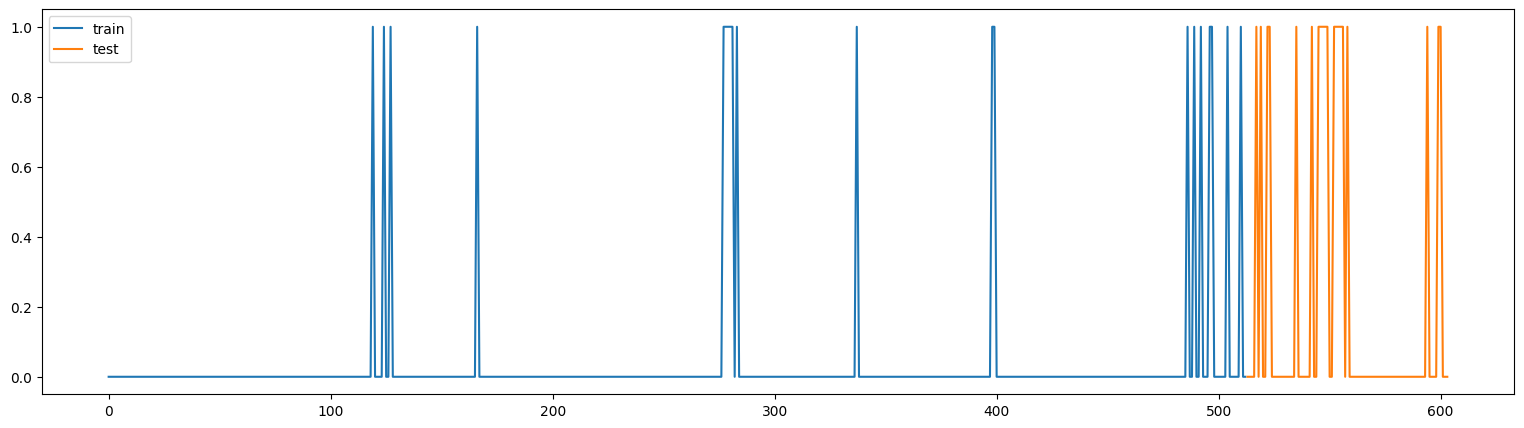

In [310]:
# Plot para ver la división train-test
x_train = np.arange(len(y_train))
x_test = np.arange(len(y_train), len(y_train) + len(y_test))

fig, ax = plt.subplots(figsize=(19, 5))
ax.plot(x_train, y_train, label='train')
ax.plot(x_test, y_test, label='test')
ax.legend()

In [311]:
len(X_train), len(y_train), len(X_test), len(y_test)

(513, 513, 91, 91)

## XGBoost
Terminamos de configurar el impact score con un modelo XGBoost que será el que nos dé el score final.

- El modelo se entrena con datos de 2023 y 2024.
- Se congela (no se vuelve a entrenar)
- Se predice con datos de 2025, que serán nuestro Impact Score del modelo final

#### Primer modelo
Al haber un desbalanceo muy elevado de las clases, el modelo va a tender a no predecir la clase 1, porque hay muy pocos casos positivos (10 de 513). Tratamos de evitarlo con el uso de parámetros.

In [314]:
# Configuración del modelo

# Calcula el peso inverso de las clases
scale = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(scale_pos_weight=scale, 
                    eval_metric='logloss', 
                    n_estimators=200, 
                    max_depth=3, 
                    learning_rate=0.01, 
                    n_jobs=1, 
                    reg_alpha=0.1, 
                    reg_lambda=1)


In [315]:
# Entrenamiento del modelo con datos de train
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=1, num_parallel_tree=None, random_state=None, ...)

In [316]:
# Evaluación del modelo con datos de train
y_proba_train = xgb.predict_proba(X_train)[:, 1]
y_pred_train = xgb.predict(X_train)
# Evaluación del modelo con datos de test
y_proba_test = xgb.predict_proba(X_test)[:, 1]
y_pred_test = xgb.predict(X_test)

threshold = 0.5
y_pred_train = (y_proba_train > threshold).astype(int)
y_pred_test = (y_proba_test > threshold).astype(int)

# Métricas
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train)

print('TRAIN')
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Report: {report}")
print("ROC AUC:", roc_auc_score(y_train, y_proba_train))

accuracy = accuracy_score(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test)

print('TEST')
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Report: {report}")
print("ROC AUC:", roc_auc_score(y_test, y_proba_test))

TRAIN
  Accuracy: 0.94
  Report:               precision    recall  f1-score   support

           0       0.99      0.94      0.97       493
           1       0.37      0.85      0.52        20

    accuracy                           0.94       513
   macro avg       0.68      0.90      0.74       513
weighted avg       0.97      0.94      0.95       513

ROC AUC: 0.9703346855983773
TEST
  Accuracy: 0.76
  Report:               precision    recall  f1-score   support

           0       0.80      0.92      0.86        71
           1       0.40      0.20      0.27        20

    accuracy                           0.76        91
   macro avg       0.60      0.56      0.56        91
weighted avg       0.71      0.76      0.73        91

ROC AUC: 0.551056338028169


#### Búsqueda de hiperparámetros

In [318]:
xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 200,
 'n_jobs': 1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'sampling_method': None,
 'scale_pos_weight': 24.65,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [319]:
# Añadimos un grid_search

# Params
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.3],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Scoring
scoring = ['neg_mean_squared_error', 'explained_variance', 'r2']

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,  
    verbose=1,
    refit='neg_mean_squared_error'
)

In [320]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=1, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [200, 300, 500]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'explained_variance', 'r2'],
             verbose=1)

In [321]:
grid_search.best_params_

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

In [322]:
best_model = grid_search.best_estimator_

In [323]:
best_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=1, num_parallel_tree=None, random_state=None, ...)

In [324]:
# Evaluación del modelo con datos de train
y_proba_train = xgb.predict_proba(X_train)[:, 1]
y_pred_train = xgb.predict(X_train)
# Evaluación del modelo con datos de test
y_proba_test = xgb.predict_proba(X_test)[:, 1]
y_pred_test = xgb.predict(X_test)

threshold = 0.5
y_pred_train = (y_proba_train > threshold).astype(int)
y_pred_test = (y_proba_test > threshold).astype(int)

# Métricas
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train)

print('TRAIN')
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Report: {report}")
print("ROC AUC:", roc_auc_score(y_train, y_proba_train))

accuracy = accuracy_score(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test)

print('TEST')
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Report: {report}")
print("ROC AUC:", roc_auc_score(y_test, y_proba_test))

TRAIN
  Accuracy: 0.94
  Report:               precision    recall  f1-score   support

           0       0.99      0.94      0.97       493
           1       0.37      0.85      0.52        20

    accuracy                           0.94       513
   macro avg       0.68      0.90      0.74       513
weighted avg       0.97      0.94      0.95       513

ROC AUC: 0.9703346855983773
TEST
  Accuracy: 0.76
  Report:               precision    recall  f1-score   support

           0       0.80      0.92      0.86        71
           1       0.40      0.20      0.27        20

    accuracy                           0.76        91
   macro avg       0.60      0.56      0.56        91
weighted avg       0.71      0.76      0.73        91

ROC AUC: 0.551056338028169


#### Entrenamiento 2023-2024
Ahora sí, se entrena el modelo final con los datos completos de 2023 a 2024 y se congela (no se vuelve a entrenar).

In [326]:
best_model.fit(X_, y_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=1, num_parallel_tree=None, random_state=None, ...)

In [327]:
# Guardamos el modelo ya entrenado como .pkl para poder usarlo en nuestra regresión lineal como una feature más 
joblib.dump(best_model, 'impact_score_xgbclass_model.pkl')

# Se podrá cargar el modelo en el notebook con el modelo final
# xgb_model = joblib.load('impact_score_xgb_model.pkl')

['impact_score_xgbclass_model.pkl']

#### Predicciones 2025 - Impact Score
Ya podemos usar el modelo entrenado anterior para predecir y obtener nuestro impact score para las noticias de 2025.

In [329]:
impact_score_2025 = best_model.predict_proba(X_2025)[:, 1]

In [330]:
impact_score_2025

array([1.0153943e-01, 1.9735454e-02, 2.8894573e-02, 2.7660143e-02,
       1.9735454e-02, 1.9735454e-02, 7.5580925e-03, 9.7157592e-03,
       3.7144843e-02, 5.6317975e-03, 1.4893002e-02, 4.0254675e-02,
       4.8763477e-03, 4.2293039e-03, 1.9645670e-03, 7.5209960e-02,
       4.2997822e-03, 1.5023290e-02, 1.8215812e-03, 1.3101910e-01,
       1.3512132e-02, 1.4865325e-03, 5.4082698e-03, 1.8215812e-03,
       1.9735454e-02, 5.6112874e-02, 6.1652899e-02, 1.9735454e-02,
       1.4255295e-02, 3.5798261e-03, 5.9012127e-01, 3.6100790e-01,
       8.8301957e-02, 5.0013888e-01, 3.7151000e-01, 4.8445620e-02,
       3.2548197e-02, 6.6522813e-01, 3.3480767e-02, 9.9684009e-03,
       2.1036286e-02, 2.6447123e-01, 1.7340513e-01, 1.3312776e-01,
       2.7178797e-01, 1.7735863e-04, 2.1620877e-01, 2.1961117e-01,
       5.9012127e-01, 2.9646491e-03, 3.9624098e-01, 5.9012127e-01,
       2.6481432e-01, 4.7363505e-02, 4.2095747e-02, 2.9450219e-02,
       5.9012127e-01, 1.0827318e-01, 2.4011008e-02, 1.4738257e

In [331]:
# Guardamos las predicciones obtenidas para usar en modelo de regresión (por problemas con kernel)
np.save("impact_score_2025_class.npy", impact_score_2025)

In [332]:
impact_score_23_24 = best_model.predict_proba(X_)[:,1]

In [333]:
# Guardamos las predicciones obtenidas para usar en modelo de regresión (por problemas con kernel)
np.save("impact_score_23_24_class.npy", impact_score_23_24)

# Weekly Data

## Dataset

In [336]:
# Cargamos los datos

### Train (2023 - 2024)
X_weekly = X_train_is_weekly
y_weekly = y_train_weekly
y_weekly = y_weekly.values.ravel() # Para convertirlo en una sola línea

### Datos para Impact Score (2025)
X_2025_weekly = X_test_is_weekly

# No se necesitan datos de la y
y_2025_weekly = y_test_weekly
y_2025_weekly = y_2025_weekly.values.ravel() # Para convertirlo en una sola línea

In [372]:
# Train-test Split
total_reg = len(X_weekly)
test_size = 0.20
total_test = round(total_reg*test_size)
total_train = total_reg-total_test
steps = total_test

X_train_weekly = X_weekly[:-steps]
y_train_weekly = y_weekly[:-steps]

X_test_weekly  = X_weekly[-steps:]
y_test_weekly  = y_weekly[-steps:]

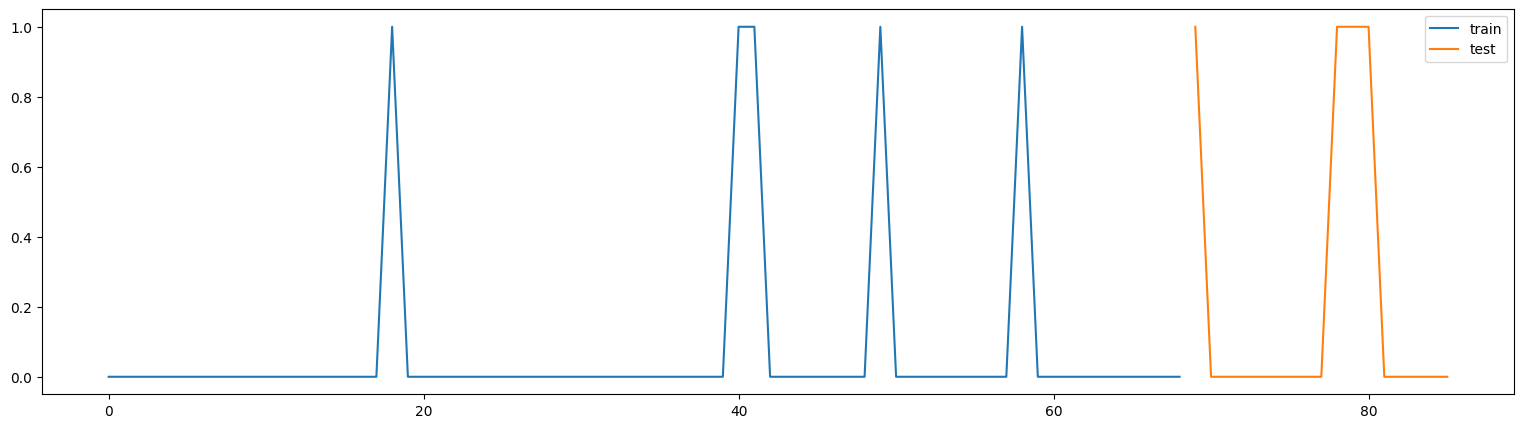

In [374]:
# Plot para ver la división train-test
x_train_weekly = np.arange(len(y_train_weekly))
x_test_weekly = np.arange(len(y_train_weekly), len(y_train_weekly) + len(y_test_weekly))

fig, ax = plt.subplots(figsize=(19, 5))
ax.plot(x_train_weekly, y_train_weekly, label='train')
ax.plot(x_test_weekly, y_test_weekly, label='test')
ax.legend()

In [376]:
len(X_train_weekly), len(y_train_weekly), len(X_test_weekly), len(y_test_weekly)

(69, 69, 17, 17)

## XGBoost
Terminamos de configurar el impact score con un modelo XGBoost que será el que nos dé el score final.

- El modelo se entrena con datos de 2023 y 2024.
- Se congela (no se vuelve a entrenar)
- Se predice con datos de 2025, que serán nuestro Impact Score del modelo final

#### Primer modelo

In [378]:
# Configuración del modelo

# Calcula el peso inverso de las clases
scale_weekly = (y_train_weekly == 0).sum() / (y_train_weekly == 1).sum()

xgb_weekly = XGBClassifier(scale_pos_weight=scale_weekly, 
                    eval_metric='logloss', 
                    n_estimators=200, 
                    max_depth=3, 
                    learning_rate=0.01, 
                    n_jobs=1, 
                    reg_alpha=0.1, 
                    reg_lambda=1)


In [380]:
# Entrenamiento del modelo con datos de train
xgb_weekly.fit(X_train_weekly, y_train_weekly)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=1, num_parallel_tree=None, random_state=None, ...)

In [382]:
# Evaluación del modelo con datos de train
y_proba_train = xgb_weekly.predict_proba(X_train_weekly)[:, 1]
y_pred_train = xgb_weekly.predict(X_train_weekly)
# Evaluación del xgb_weekly con datos de test
y_proba_test = xgb_weekly.predict_proba(X_test_weekly)[:, 1]
y_pred_test = xgb_weekly.predict(X_test_weekly)

threshold = 0.25
y_pred_train = (y_proba_train > threshold).astype(int)
y_pred_test = (y_proba_test > threshold).astype(int)

# Métricas
accuracy = accuracy_score(y_train_weekly, y_pred_train)
report = classification_report(y_train_weekly, y_pred_train)

print('TRAIN')
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Report: {report}")
print("ROC AUC:", roc_auc_score(y_train_weekly, y_proba_train))

accuracy = accuracy_score(y_test_weekly, y_pred_test)
report = classification_report(y_test_weekly, y_pred_test)

print('TEST')
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Report: {report}")
print("ROC AUC:", roc_auc_score(y_test_weekly, y_proba_test))

TRAIN
  Accuracy: 0.88
  Report:               precision    recall  f1-score   support

           0       1.00      0.88      0.93        64
           1       0.38      1.00      0.56         5

    accuracy                           0.88        69
   macro avg       0.69      0.94      0.74        69
weighted avg       0.96      0.88      0.91        69

ROC AUC: 1.0
TEST
  Accuracy: 0.76
  Report:               precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.50      0.50      0.50         4

    accuracy                           0.76        17
   macro avg       0.67      0.67      0.67        17
weighted avg       0.76      0.76      0.76        17

ROC AUC: 0.673076923076923


#### Búsqueda de hiperparámetros

In [384]:
xgb_weekly.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 200,
 'n_jobs': 1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'sampling_method': None,
 'scale_pos_weight': 12.8,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [386]:
# Añadimos un grid_search

# Params
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.3],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Scoring
scoring = ['neg_mean_squared_error', 'explained_variance', 'r2']

grid_search = GridSearchCV(
    estimator=xgb_weekly,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,  
    verbose=1,
    refit='neg_mean_squared_error'
)

In [388]:
grid_search.fit(X_train_weekly, y_train_weekly)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=1, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [200, 300, 500]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'explained_variance', 'r2'],
             verbose=1)

In [389]:
grid_search.best_params_

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}

In [390]:
best_model_weekly = grid_search.best_estimator_

In [391]:
best_model_weekly.fit(X_train_weekly,y_train_weekly)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=1, num_parallel_tree=None, random_state=None, ...)

In [392]:
# Evaluación del modelo con datos de train
y_proba_train = xgb_weekly.predict_proba(X_train_weekly)[:, 1]
y_pred_train = xgb_weekly.predict(X_train_weekly)
# Evaluación del xgb_weekly con datos de test
y_proba_test = xgb_weekly.predict_proba(X_test_weekly)[:, 1]
y_pred_test = xgb_weekly.predict(X_test_weekly)

threshold = 0.25
y_pred_train = (y_proba_train > threshold).astype(int)
y_pred_test = (y_proba_test > threshold).astype(int)

# Métricas
accuracy = accuracy_score(y_train_weekly, y_pred_train)
report = classification_report(y_train_weekly, y_pred_train)

print('TRAIN')
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Report: {report}")
print("ROC AUC:", roc_auc_score(y_train_weekly, y_proba_train))

accuracy = accuracy_score(y_test_weekly, y_pred_test)
report = classification_report(y_test_weekly, y_pred_test)

print('TEST')
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Report: {report}")
print("ROC AUC:", roc_auc_score(y_test_weekly, y_proba_test))

TRAIN
  Accuracy: 0.88
  Report:               precision    recall  f1-score   support

           0       1.00      0.88      0.93        64
           1       0.38      1.00      0.56         5

    accuracy                           0.88        69
   macro avg       0.69      0.94      0.74        69
weighted avg       0.96      0.88      0.91        69

ROC AUC: 1.0
TEST
  Accuracy: 0.76
  Report:               precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.50      0.50      0.50         4

    accuracy                           0.76        17
   macro avg       0.67      0.67      0.67        17
weighted avg       0.76      0.76      0.76        17

ROC AUC: 0.673076923076923


#### Entrenamiento 2023-2024
Ahora sí, se entrena el modelo final con los datos completos de 2023 a 2024 y se congela (no se vuelve a entrenar).

In [398]:
best_model_weekly.fit(X_weekly, y_weekly)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=1, num_parallel_tree=None, random_state=None, ...)

In [402]:
# Guardamos el modelo ya entrenado como .pkl para poder usarlo en nuestra regresión lineal como una feature más 
joblib.dump(best_model_weekly, 'impact_score_xgbclass_model_weekly.pkl')

# Se podrá cargar el modelo en el notebook con el modelo final
# xgb_model_weekly = joblib.load('impact_score_xgb_model_weekly.pkl')

['impact_score_xgbclass_model_weekly.pkl']

#### Predicciones 2025 - Impact Score
Ya podemos usar el modelo entrenado anterior para predecir y obtener nuestro impact score para las noticias de 2025.

In [404]:
len(X_2025_weekly)

15

In [406]:
impact_score_2025_weekly = best_model_weekly.predict_proba(X_2025_weekly)[:,1]

In [408]:
impact_score_2025_weekly

array([0.00039817, 0.0785211 , 0.01088725, 0.1479416 , 0.09108832,
       0.00717509, 0.00802759, 0.07043271, 0.00118444, 0.07150629,
       0.02552397, 0.00117918, 0.01005599, 0.01632266, 0.00059001],
      dtype=float32)

In [410]:
# Guardamos las predicciones obtenidas para usar en modelo de regresión (por problemas con kernel)
np.save("impact_score_2025_weekly_class.npy", impact_score_2025_weekly)

In [412]:
impact_score_23_24_weekly = best_model_weekly.predict_proba(X_weekly)[:,1]

In [414]:
# Guardamos las predicciones obtenidas para usar en modelo de regresión (por problemas con kernel)
np.save("impact_score_23_24_weekly_class.npy", impact_score_23_24_weekly)